In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from pathlib import Path

%load_ext autoreload
%autoreload 2
from base import datahandler, prediction_models, evaluation

2024-01-07 15:22:04.114430: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-07 15:22:04.114493: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-07 15:22:04.115342: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-07 15:22:04.121473: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-07 15:22:05.075166: W tensorflow/compiler/tf2

In [2]:
# Define the directory paths
challenge_data_dir = Path('dataset/phase_1/')
data_dir = challenge_data_dir / "train"
labels_dir = challenge_data_dir / 'train_labels.csv'

split_dataframes = datahandler.load_and_prepare_dataframes(data_dir, labels_dir)

some_dataframes = {df_k : split_dataframes[df_k] for df_k in list(split_dataframes.keys())[:100]}

In [18]:
input_features = ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)',
       'Argument of Periapsis (deg)', 'True Anomaly (deg)', 'Latitude (deg)',
       'Longitude (deg)', 'Altitude (m)', 'X (m)', 'Y (m)', 'Z (m)',
       'Vx (m/s)', 'Vy (m/s)', 'Vz (m/s)']

input_features_reduced = ['Eccentricity', 'Semimajor Axis (m)', 'Inclination (deg)', 'RAAN (deg)',
       'Argument of Periapsis (deg)', 'True Anomaly (deg)', 'Latitude (deg)',
       'Longitude (deg)', 'Altitude (m)']

label_features=['EW_Type', 'EW_Node_Location']

ds_gen = datahandler.DatasetGenerator(split_df=split_dataframes, input_features=input_features_reduced,
                                      label_features=label_features,
                                      train_val_split=0.85, stride=1, input_stride=2, padding=False,
                                      input_history_steps=20, input_future_steps=20, seed=69)

=========================Creating Dataset=========================
Seed: 69
nTrain: 212 nVal: 38 (0.85)
Padding: False
Scaling: True
Horizons: 20-20 @ stride 2
Sin-Transformed features: ['True Anomaly (deg)', 'Argument of Periapsis (deg)']
Labels: ['EW_Type_encoded', 'EW_Node_Location']
=========================Finished Dataset=========================


In [37]:
train_combined, val_combined = ds_gen.get_datasets(batch_size=256, label_features=['EW_Type'], keep_identifier=False, shuffle=False)
# train_combined = train_combined.filter(lambda x,y:y['EW_Node_Location']==1)
# val_combined = val_combined.filter(lambda x,y:y['EW_Node_Location']==1)
# train_combined = train_combined.map(lambda x,y:(x,{'EW':y['EW']}))
# val_combined = val_combined.map(lambda x,y:(x,{'EW':y['EW']}))
# train_combined = train_combined.batch(32)
# val_combined = val_combined.batch(32)
print(train_combined.element_spec)

(TensorSpec(shape=(None, 20, 9), dtype=tf.float64, name=None), {'EW_Type': TensorSpec(shape=(None,), dtype=tf.int32, name=None)})


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 20, 9)]           0         
                                                                 
 lstm (LSTM)                 (None, 20, 48)            11136     
                                                                 
 dropout_10 (Dropout)        (None, 20, 48)            0         
                                                                 
 lstm_1 (LSTM)               (None, 48)                18624     
                                                                 
 dropout_11 (Dropout)        (None, 48)                0         
                                                                 
 flatten_3 (Flatten)         (None, 48)                0         
                                                                 
 dense_10 (Dense)            (None, 16)                784 

/home/david/Code/splid-challenge/base/prediction_models.py:69: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


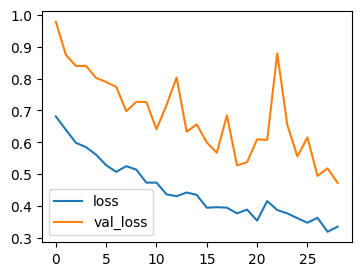

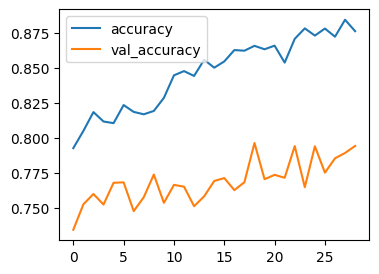

In [38]:
#dense_model = prediction_models.Dense_NN(val_combined, conv1d_layers=[], dense_layers=[256,128,64], l2_reg=0.001, mixed_dropout=0.15, lr_scheduler=[30000,0.9], seed=0)
#dense_model = prediction_models.CNN(train_combined, conv_layers=[[64,6],[64,3],[64,3]], l2_reg=0.001, mixed_dropout=0.15, lr_scheduler=[20000,0.8], seed=0)
#dense_model = prediction_models.Dense_NN(train_combined, conv1d_layers=[[64,6],[64,6]], dense_layers=[128,64,32], l2_reg=0.001, mixed_dropout=0.15, lr_scheduler=[25000,0.9], seed=0)
dense_model = prediction_models.LSTM_NN(train_combined, input_dropout=0.0, mixed_dropout=0.15, lstm_layers=[48,48], dense_layers=[16], l2_reg=0.0001, lr_scheduler=[25000,0.9], seed=1)

dense_model.summary()
hist = dense_model.fit(train_combined, val_ds=val_combined, epochs=30, verbose=1, plot_hist=False, callbacks=[])

dense_model.plot_hist(hist, [k for k in hist.history.keys() if 'loss' in k])
dense_model.plot_hist(hist, [k for k in hist.history.keys() if 'accuracy' in k])

In [39]:
def classification_eval(ds_gen, gt_path, model, train=True):

    t_ds, v_ds = ds_gen.get_datasets(batch_size=None, label_features=label_features, shuffle=False, keep_identifier=True)
    ds = t_ds if train else v_ds
    # only predict on the necessary locations
    ds = ds.filter(lambda x,y,z:y['EW_Node_Location']==1)
    #ds = ds.map(lambda x,y,z:(x,{'EW':y['EW']},z))
    ds = ds.map(lambda x,y,z:(x,{'EW_Type':y['EW_Type']},z))
    ds = ds.batch(32)

    ground_truth_from_file = pd.read_csv(gt_path).sort_values(['ObjectID', 'TimeIndex']).reset_index(drop=True)
    ground_truth_from_file = ground_truth_from_file[ground_truth_from_file['ObjectID'].isin(map(int, ds_gen.train_keys if train else ds_gen.val_keys))].copy()
    ground_truth_from_file = ground_truth_from_file[(ground_truth_from_file['Direction'] == 'EW')]
    ground_truth_from_file[['Node_gt', 'Type_gt']] = ground_truth_from_file[['Node', 'Type']]

    inputs = np.concatenate([element for element in ds.map(lambda x,y,z: x).as_numpy_iterator()])
    #labels = np.concatenate([element['EW_Node_Location'] for element in ds.map(lambda x,y,z: y).as_numpy_iterator()])
    identifiers = np.concatenate([element for element in ds.map(lambda x,y,z: z).as_numpy_iterator()])

    # get predictions
    preds = model.predict(inputs)
    preds_argmax = np.argmax(preds, axis=1)

    df = pd.DataFrame(np.concatenate([identifiers.reshape(-1,2)], axis=1), columns=['ObjectID', 'TimeIndex'], dtype=np.int32)
    #df['Location'] = labels
    df[f'EW_Pred'] = preds_argmax
    #df[f'EW_Pred_Decoded'] = ds_gen.combined_label_encoder.inverse_transform(df[f'EW_Pred'])
    #df[['Node', 'Type']] = df['EW_Pred_Decoded'].str.split('-', expand=True)
    df[f'Type'] = ds_gen.type_label_encoder.inverse_transform(df[f'EW_Pred'])
    
    
    df_filtered = df.sort_values(['ObjectID', 'TimeIndex']).reset_index(drop=True)

    # now, assign the real label to the locations
    mergeDf = df_filtered.merge(ground_truth_from_file[['ObjectID', 'TimeIndex', 'Direction','Node', 'Type_gt']], how='right', on = ['ObjectID', 'TimeIndex'])
    mergeDf.loc[(mergeDf['Type'].isna()), 'Type'] = mergeDf['Type_gt'] # Temporary fix as I forgot to use padding

    evaluator = evaluation.NodeDetectionEvaluator(ground_truth_from_file, mergeDf)
    precision, recall, f2, rmse, total_tp, total_fp, total_fn = evaluator.score()
    print(f'Precision: {precision:.2f}')
    # print(f'Recall: {recall:.2f}')
    # print(f'F2: {f2:.2f}')
    # print(f'RMSE: {rmse:.4}')
    print(f'TP: {total_tp} FP: {total_fp}')

    return mergeDf

In [40]:
eval_df = classification_eval(ds_gen, challenge_data_dir / 'train_labels.csv', dense_model.model, train=False)
print(eval_df[['ObjectID', 'TimeIndex', 'Node', 'Type', 'Type_gt']].head(20))

1/1 [==============================] - 1s 545ms/step
Precision: 0.73
TP: 48 FP: 18
    ObjectID  TimeIndex Node Type Type_gt
0         10          0   SS   CK      CK
1         15          0   SS   EK      EK
2         21          0   SS   HK      HK
3         26          0   SS   CK      CK
4         30          0   SS   CK      CK
5         45          0   SS   CK      CK
6         47          0   SS   CK      CK
7         52          0   SS   CK      CK
8         60          0   SS   CK      CK
9         61          0   SS   CK      CK
10        66          0   SS   CK      CK
11        73          0   SS   CK      CK
12        84          0   SS   CK      CK
13        87          0   SS   CK      CK
14        91          0   SS   CK      CK
15       114          0   SS   NK      NK
16       114        200   AD   NK      NK
17       114        206   IK   NK      HK
18       116          0   SS   NK      NK
19       116        200   AD   NK      NK


In [41]:
eval_df = classification_eval(ds_gen, challenge_data_dir / 'train_labels.csv', dense_model.model, train=True)


7/7 [==============================] - 0s 7ms/step
Precision: 0.77
TP: 333 FP: 98
